# Classification. Linear models and KNN

In [62]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [87]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [64]:
from sklearn.exceptions import NotFittedError

In [65]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        if X.shape[1] < weights.shape[0]:
            a = np.ones(X.shape[0])
            X=np.insert(X, 0, a, axis = 1)
        Z = X @ weights
        return 1 / (1 + np.exp(-Z))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        if x.shape[1] < weights.shape[0]:
            a = np.ones(x.shape[0])
            x=np.insert(x, 0, a, axis = 1)
        Z = x @ weights
        Z = Z * y
        loss = sum(np.log(1 + np.exp(-Z)))/x.shape[0] + (np.linalg.norm(weights)**2)/(2*self.C)
        return loss
    
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.  
        """
        #вычисляем дельту отдельной функцией
        def calc_delta(x, weights, y):
            """Calculate the delta."""
            z = x @ weights
            z = z * y
            z = 1 - 1 / (1 + np.exp(-z))
            return weights/self.C - ((y*z) @ x)/x.shape[0]
        
        #the loss history array
        self.loss = []
        
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            delta = calc_delta(X_ext, self.weights_, y)
            self.loss.append(self.get_loss(X_ext, self.weights_, y))
            self.weights_ -= self.eta * delta
            if np.linalg.norm(self.eta * delta) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        y = self.get_sigmoid(X_ext, self.weights_)
        return np.sign(y-0.5)
        

In [66]:
from sklearn import datasets
from sklearn import metrics

[6 0 0 ... 2 7 1]
(1437,)


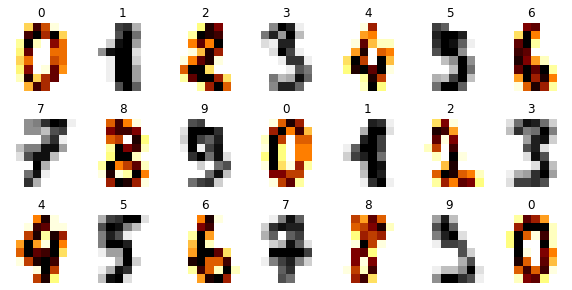

In [67]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print(y_train)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1
print(y_train.shape)

In [68]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [69]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [70]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [71]:
# первая проверка прошла

In [72]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [73]:
lr_clf.fit(X_train, y_train)

In [74]:
lr_clf.weights_

array([ 3.13152401e-06,  0.00000000e+00,  4.17536534e-05,  5.47668754e-04,
        2.21294363e-04,  4.87473904e-04,  1.35768963e-03,  5.97773138e-04,
        5.63674322e-05, -6.95894224e-07,  1.69102296e-04,  2.51913709e-04,
       -4.37021573e-04,  3.61864997e-04,  1.00487126e-03,  4.22755741e-04,
        2.57480863e-05,  3.47947112e-07, -1.14822547e-05, -7.24425887e-04,
       -2.62004175e-04,  8.75434934e-04,  4.15448852e-04, -8.42032011e-05,
       -5.21920668e-06,  0.00000000e+00, -2.21642310e-04, -5.71329158e-04,
        9.85734168e-04,  1.35073069e-03,  5.02087683e-04, -1.70494085e-04,
       -1.04384134e-06,  0.00000000e+00, -6.78148921e-04, -1.05149617e-03,
       -4.45372303e-05,  3.71607516e-04,  4.21016006e-04, -8.17675713e-05,
        0.00000000e+00, -5.21920668e-06, -5.34098817e-04, -2.03931802e-03,
       -8.43075852e-04,  1.04036186e-04, -1.23869172e-04, -1.78844816e-04,
       -1.32219903e-05, -4.52331246e-06, -9.42936674e-05, -1.11273486e-03,
       -5.09046625e-04, -

In [75]:
#вторая проверка прошла

In [76]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [77]:
model = CustomLogisticRegression()

In [78]:
#третья проверка прошла

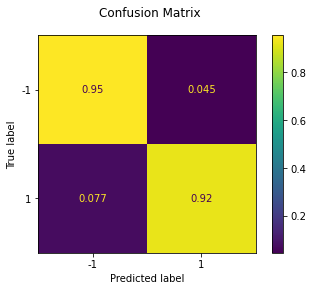

In [79]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [80]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [81]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

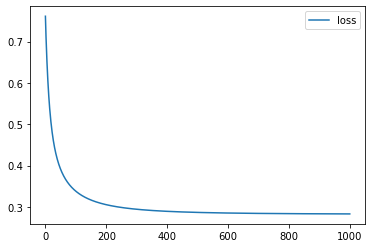

In [41]:
## your code
model = CustomLogisticRegression()
model.fit(X_train, y_train)
plt.plot(range(1000), model.loss, label='loss')
plt.legend()

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

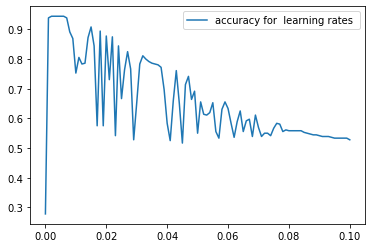

In [43]:
## your code
ALPHAS = np.linspace(0, 0.1, 1 + 100)
accuracy_rates = []
for alpha in ALPHAS:
    model = CustomLogisticRegression(eta = alpha)
    model.fit(X_train, y_train)
    accuracy_rates.append(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))
plt.plot(ALPHAS, accuracy_rates, label='accuracy for  learning rates ')
plt.legend()  


< your thoughts >

**(0.5 points)** Try different regularization parameter values and compare the model quality.

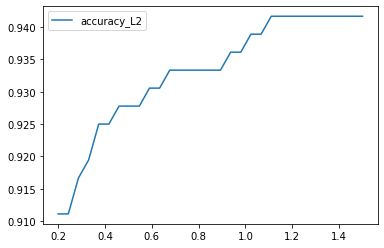

In [324]:
## your code
L2_PARAM = np.linspace(0.2, 1.5, 1 + 30)
#print(L2_PARAM)
accuracy_L2 = []
for alpha in L2_PARAM:
    model = CustomLogisticRegression(C = alpha)
    model.fit(X_train, y_train)
    accuracy_L2.append(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))
plt.plot(L2_PARAM, accuracy_L2, label='accuracy_L2')
plt.legend()
#print(accuracy_L2)

< your thoughts >

**(0.5 points)** Compare zero initialization and random initialization. 

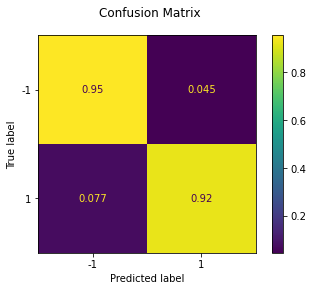

In [311]:
## your code
model = CustomLogisticRegression(zero_init=False)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

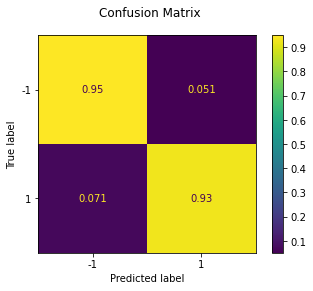

In [312]:
model = CustomLogisticRegression(zero_init=True)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

< your thoughts >

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [19]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        P = np.zeros((X.shape[0],Y.shape[0]))
        for i in range(X.shape[0]):
            for j in range(Y.shape[0]):
                P[i][j] = np.linalg.norm(X[i]-Y[j])
        return P
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        p = np.zeros(len(self.classes_))
        for i in range(len(self.classes_)):
            for j in range(y.shape[0]):
                if self.classes_[i] == y[j]:
                    p[i]+=weights[j]
        return p
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
           
            y = np.zeros((X.shape[0],len(self.classes_)))         
            weights_of_points = np.ones(P.shape)
            
            
            if self.weights == 'distance':
                weights_of_points = 1/(P +self.eps)
                
            for i in range(P.shape[0]):
                for j in range(P.shape[1]-self.n_neighbors):
                    P[i,np.argmax(P[i,:])]=-1
                        
            for i in range(P.shape[0]):
                weights_knn = []
                y_knn = []
                for j in range(P.shape[1]):
                    if P[i,j]>=0:
                        weights_knn.append(weights_of_points[i,j])
                        y_knn.append(self.y[j])
                y_class = self.get_class_weights(np.array(y_knn),np.array(weights_knn))
                sum_knn = sum(y_class)
                
                
                for j in range(len(self.classes_)):
                    y[i,j] = y_class[j]/sum_knn
            
            return y
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        y = np.argmax(self.predict_proba(X),axis = 1)
        for i in range(len(y)):
            y[i] = self.classes_[y[i]]
        
        return y

In [20]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [21]:
#первый ассерт прошел

In [22]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [23]:
# второй ассерт прошел

In [24]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

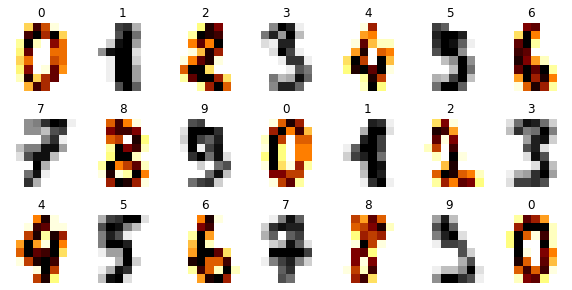

In [25]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [26]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [28]:
#третий ассерт прошел
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

(360, 1437)


(360, 1437)


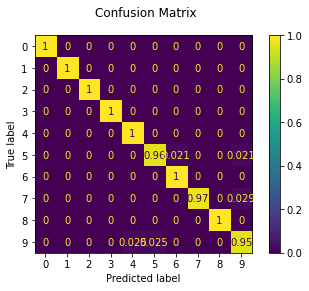

(1437, 1437)
(360, 1437)


In [29]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [30]:
print(train_acc,test_acc)

1.0 0.9861111111111112


In [31]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Не самые идеальные результаты мы видим для цифр 5 и 9, и это как раз очень близкие по начертанию цифры. Если посмотреть на визуализацию цифр чуть выше, то видно что в первом наборе цифр 5 и 9 практически не отличаются. Так же мы не смогли распознать все цифры 7, опять же, если визуально посмотреть на изображения цифр, то можно предположить, что это связано с более ярко выраженной перекладиной в одних случаях, и пратически отсутствующей перекладиной в других

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [ ]:
## your code


< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [32]:
## your code
model = CustomKNeighborsClassifier(n_neighbors=5)
knn = KNeighborsClassifier(n_neighbors=5)

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

В данной задаче использовалось евклидово расстояние (евлкдидова норма), данная метрика является наиболее распространенной.
Также она является частным случаем расстояни Минковского, которое вычисляется по формуле 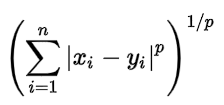
в случе p=2 как раз и получается евклидово расстояние.
Случай p=1 называется Манхэттенское расстояние, оно используется, если нужно рассчитать расстояние между двумя точками данных в виде сетки, как путь.
В задачах классификации и кластеризации чаще всего используется именно евклидово расстояние.

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

В качестве другой задачи и другой метрики для расстояния можно предложить задачу по обработке естественного языка. В таких задачах используется метрика косинусного сходства, для поиска сходства между документами, преобразованными в векторную форму.
Однако данный тип задач выходит за рамки этого модуля. 

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [194]:
PATH = "./data/"

In [230]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [231]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

<AxesSubplot:ylabel='Sex'>

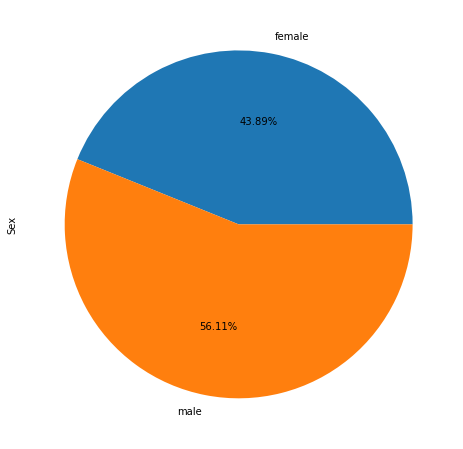

In [6]:
data.groupby(['Sex'])['Sex'].count().plot(kind='pie',figsize=(12,8),autopct='%.2f%%')

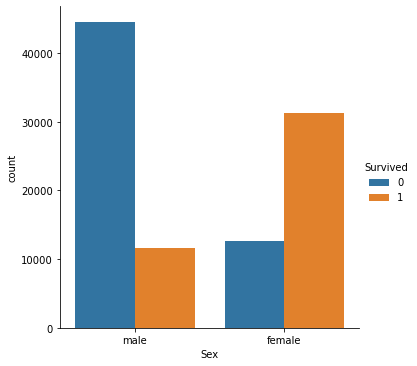

In [7]:
sns.catplot(x='Sex', data=data, kind="count", hue='Survived')

Как видно из круговой диаграммы, большинство пассажиров - мужчины, однако второй график показывает что среди выживших женщин в два с лишним раза больше. Таким образом можно сделать вывод, что пол является значимым признаком для выживаемости.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

<ipython-input-22-74b49694da72>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


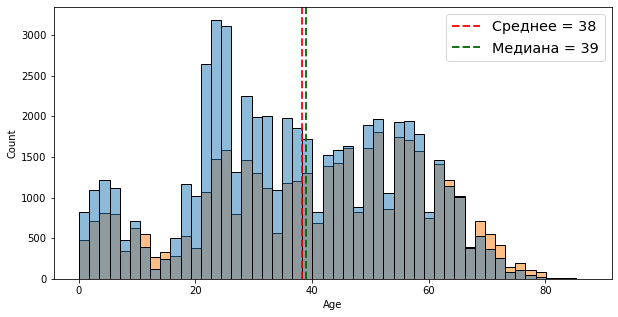

In [22]:
## your code
fig = plt.figure(figsize = (10, 5))
g = sns.histplot(data=data,x="Age",bins=50)
ax = fig.add_subplot(1, 1, 1)
g.axvline(data['Age'].mean(), linewidth=2, color='r', alpha=0.9, linestyle='--', label = 'Среднее = {:,.0f}'.format(data['Age'].mean()).replace(',', ' '))
g.axvline(data['Age'].median(), linewidth=2, color='darkgreen', alpha=0.9, linestyle='--', label = 'Медиана = {:,.0f}'.format(data['Age'].median()).replace(',', ' '))
plt.ticklabel_format(axis='x', style='plain')
plt.ticklabel_format(axis='x', style='plain')
plt.legend(fontsize="x-large")
plt.show()

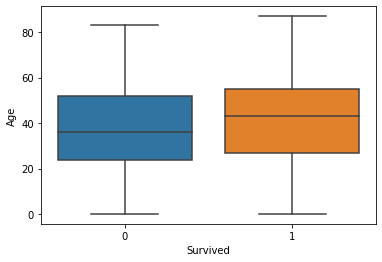

In [8]:
sns.boxplot( y=data["Age"], x=data["Survived"] )
plt.show()

In [9]:
data.groupby(data['Survived'])['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,55290.0,36.708695,17.809058,0.08,24.0,36.0,52.0,83.0
1,41418.0,40.553799,18.742172,0.08,27.0,43.0,55.0,87.0


Как мы видим, большинство пассажиров были в возрасте от 20 до 60, среднее и медиана практически совпадают, но если сравнивать распределение по возрасту относительно выживаемости, то видим, что и среднее и медиана среди выживших смещены к более старшему возрасту. По всей видимости это связано опять же с распределением по классам кают. Среди респектабельных пассажиров первого класса больше людей старшего возраста, в то время как основную часть пассажиров третьего класса составляли молодые мужчины.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

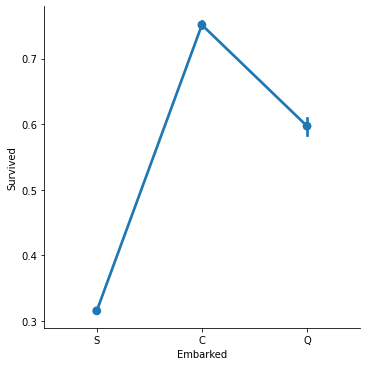

In [10]:
## your code
sns.catplot(x = 'Embarked',y = 'Survived',data=data, kind = 'point')
# как видим наиболее высокие шансы у севших на Титаник в Cherbourg, и самые низкие - в Southampton

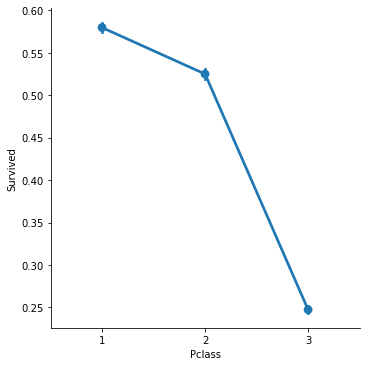

In [11]:
sns.catplot(x = 'Pclass',y = 'Survived',data=data, kind = 'point')
# как видим наиболее высокие шансы у пассажиров первого класса, и самые низкие - третьего

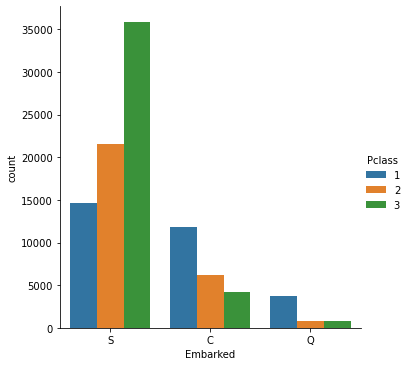

In [12]:
# однако, если отследить взаимосвязь места посадки и класса
sns.catplot(x='Embarked', data=data, kind="count", hue='Pclass')
# то увидим, что значительная часть пассажиров третьего класса, у которых шанс выжить был гораздо меньше поднялась на борт именно в Southampton

Казалось бы мы видим зависимость выживыемости от места посадки, но полагаю, что определяющим признаком всё таки является именно 
класс каюты пассажира. И большинство погибших было из Southampton именно потому, что там поднялось на борт подавляющее большинство пассажиров третьего класса.  

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [232]:
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, pct_missing*100))

Survived - 0.0%
Pclass - 0.0%
Name - 0.0%
Sex - 0.0%
Age - 3.292%
SibSp - 0.0%
Parch - 0.0%
Ticket - 4.623%
Fare - 0.134%
Cabin - 67.866%
Embarked - 0.25%


In [233]:
data.describe(include = 'all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,100000.000000,100000.000000,100000,100000,96708.000000,100000.000000,100000.000000,95377,99866.00000,32134,99750
unique,NaN,NaN,92144,2,NaN,NaN,NaN,75331,NaN,26992,3
top,NaN,NaN,"Johnson, John",male,NaN,NaN,NaN,A/5,NaN,C19828,S
freq,NaN,NaN,31,56114,NaN,NaN,NaN,602,NaN,6,72139
mean,0.427740,2.106910,NaN,NaN,38.355472,0.397690,0.454560,NaN,43.92933,NaN,NaN
std,0.494753,0.837727,NaN,NaN,18.313556,0.862566,0.950076,NaN,69.58882,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.080000,0.000000,0.000000,NaN,0.68000,NaN,NaN
25%,0.000000,1.000000,NaN,NaN,25.000000,0.000000,0.000000,NaN,10.04000,NaN,NaN
50%,0.000000,2.000000,NaN,NaN,39.000000,0.000000,0.000000,NaN,24.46000,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,53.000000,1.000000,1.000000,NaN,33.50000,NaN,NaN


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

1. Возраст является значимым признаком, т.е. мы хотим его использовать в модели и должны обработать пропуски. Можно удалить строки с пропусками, одако это приведет к потере данных. Другим способом избавиться от NaN является заполнение пропусков например средним или медианным значением. Учитывая график распределения возраста, думаю в данном случае это будет лучшим вариантом. Также можно заполнять пропуски средним по той или иной категории.
    Аналогично можно поступить и со стоимостью билета.
2. Номер билета представляет слишком большое разнообразие, ряд билетов содержит только цифры, ряд и цифры и буквы, на первый взгляд, отсутствует связь и с портом посадки, и с классом билета. В этом случае можно вообще не использовать данный признак в нашей модели.
3. Каюта. Отсуствует 68% данных. Наиболее распростаненным приемом в данном случае является удаление столбца, как малоинформативного. Однако можно исследовать взаимосвязь между отсутствием данного признака и целевой переменной. Если такая взаимосвязь есть, то лучшим вариантом будет заполнить признаки неким идентификатором, например "No" или "0" и использовать в модели. 
4. Порт посадки является категориальной переменной и здесь мы не можем заполнить средним. Есть два варианта, удалить строки с пропусками либо заполнить наиболее часто встречающимся значением. Т.к. в нашам случае из 99750 записей 72139 принимают значение "S", выбираем второй вариант.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [234]:
## your code
#заполним пропуски 
data['Age'].fillna(data.groupby('Sex')['Age'].transform('median'), inplace = True)
data['Fare'].fillna(data.groupby('Pclass')['Fare'].transform('median'), inplace = True)
data.fillna(value = {'Embarked':'S'}, inplace = True)

In [235]:
#остались пропущенные значения в Ticket и в Cabin, но в первом приближении я не планирую использовать эти столбцы
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       100000 non-null  float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      100000 non-null  float64
 9   Cabin     32134 non-null   object 
 10  Embarked  100000 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [236]:
#т.к. у нас есть категориальные признаки, с ними надо что-то делать. Сначала попробуем просто закодировать их числами(что не всегда хорошо)
genders = {"male": 0, "female": 1}
data["SexF"] = data["Sex"].apply(lambda s: genders.get(s))
embarkments = {"S": 1, "C": 2, "Q": 3}
data["EmbarkedF"] = data["Embarked"].apply(lambda e: embarkments.get(e))

In [237]:
## определим цель и признаки, которые будем использовать для первоначального построения модели
target = ['Survived']
features = ['Pclass','SexF', 'Age', 'SibSp', 'Parch','Fare','EmbarkedF']

In [238]:
y = np.array(data[target]).ravel()
X = data[features]

In [239]:
scaler = StandardScaler()
scaler.fit(X[features])
X = scaler.transform(X[features])

In [240]:
#LogisticRegression
model_LR = LogisticRegression()
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#train_acc, test_acc = fit_evaluate(model_LR, X_train, y_train, X_test, y_test)
scores = cross_val_score(model_LR, X,y, cv=5)
print("Score (logistic regression): {}/{}".format(scores.mean(), scores.std()))

Score (logistic regression): 0.75817/0.0021091704530454857


In [241]:
#KNN
model_knn = KNeighborsClassifier(n_neighbors=5)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#train_acc, test_acc = fit_evaluate(model_knn, X_train, y_train, X_test, y_test)
scores = cross_val_score(model_knn, X, y, cv=5)
print("Score (Knn): {}/{}".format(scores.mean(), scores.std()))

Score (Knn): 0.74133/0.0013818827736099871


Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [242]:
#попробуем вместо ручной замены на цифры категориальных переменных быстрое кодирование (One-Hot Encoding)
gender_dummies = pd.get_dummies(data["Sex"], prefix="SexH", dummy_na=False)
data = pd.concat([data, gender_dummies], axis=1)
embarkment_dummies = pd.get_dummies(data["Embarked"], prefix="EmbarkedH", dummy_na=False)
data = pd.concat([data, embarkment_dummies], axis=1)

In [243]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexF,EmbarkedF,SexH_female,SexH_male,EmbarkedH_C,EmbarkedH_Q,EmbarkedH_S
PassengerId,,,,,,,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,36.00,2,0,209245,27.14,C12239,S,0,1,0,1,0,0,1
1,0,3,"Bryan, Drew",male,36.00,0,0,27323,13.35,NaN,S,0,1,0,1,0,0,1
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S,0,1,0,1,0,0,1
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S,0,1,0,1,0,0,1
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S,0,1,0,1,0,0,1


In [244]:
#соответственно изменится и наш входной набор данных
target = ['Survived']
features = ['Pclass','SexH_female', 'SexH_male','Age', 'SibSp', 'Parch','Fare','EmbarkedH_C','EmbarkedH_Q','EmbarkedH_S']
y = np.array(data[target]).ravel()
X = data[features]
scaler = StandardScaler()
scaler.fit(X[features])
X = scaler.transform(X[features])

In [245]:
#LogisticRegression
model_LR = LogisticRegression()
scores = cross_val_score(model_LR, X,y, cv=5)
print("Score: {}/{}".format(scores.mean(), scores.std()))
#уже лучше, но ненамного

Score: 0.76671/0.0013544002362669606


In [246]:
#попробуем добавить признак палубы (он зависит от первого символа признака Cabin)
# создадим дополнительный столбец, указывающий палубу расположения каюты, заменив предварительно NaN на Z - признак отсутствия каюты
data.loc[data['Cabin'].isnull(),'Cabin'] ='Z' 
levels = []
for level in data['Cabin']:
    levels.append(level[0])
data['Desk'] = levels

In [247]:
# и применим быстрое кодирование (One-Hot Encoding)
desk_dummies = pd.get_dummies(data["Desk"], prefix="DeskD", dummy_na=False)
data = pd.concat([data, desk_dummies], axis=1)

In [288]:
#повторим построение модели
target = ['Survived']
features = ['Pclass','SexH_female', 'SexH_male','Age', 'SibSp', 'Parch','Fare','EmbarkedH_C','EmbarkedH_Q','EmbarkedH_S','DeskD_A','DeskD_B','DeskD_C','DeskD_D','DeskD_E','DeskD_F','DeskD_G','DeskD_T','DeskD_Z']
y = np.array(data[target]).ravel()
X = data[features]
scaler = StandardScaler()
scaler.fit(X[features])
X = scaler.transform(X[features])

In [289]:
#LogisticRegression
model_LR = LogisticRegression(C = 0.001)
scores = cross_val_score(model_LR, X,y, cv=5)
print("Score: {}/{}".format(scores.mean(), scores.std()))
#и еще лучше, но все равно не хватает

Score: 0.77272/0.0013862178760930734


In [259]:
#поготовка данных на тестовом наборе
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Pclass       100000 non-null  int64  
 2   Name         100000 non-null  object 
 3   Sex          100000 non-null  object 
 4   Age          96513 non-null   float64
 5   SibSp        100000 non-null  int64  
 6   Parch        100000 non-null  int64  
 7   Ticket       94819 non-null   object 
 8   Fare         99867 non-null   float64
 9   Cabin        29169 non-null   object 
 10  Embarked     99723 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 8.4+ MB


In [260]:
#заполним пропуски 
data_test['Age'].fillna(data_test.groupby('Sex')['Age'].transform('median'), inplace = True)
data_test['Fare'].fillna(data_test.groupby('Pclass')['Fare'].transform('median'), inplace = True)
data_test.fillna(value = {'Embarked':'S'}, inplace = True)

In [261]:
gender_dummies = pd.get_dummies(data_test["Sex"], prefix="SexH", dummy_na=False)
data_test = pd.concat([data_test, gender_dummies], axis=1)
embarkment_dummies = pd.get_dummies(data_test["Embarked"], prefix="EmbarkedH", dummy_na=False)
data_test = pd.concat([data_test, embarkment_dummies], axis=1)

In [262]:
data_test.loc[data_test['Cabin'].isnull(),'Cabin'] ='Z' 
levels = []
for level in data_test['Cabin']:
    levels.append(level[0])
data_test['Desk'] = levels
desk_dummies = pd.get_dummies(data_test["Desk"], prefix="DeskD", dummy_na=False)
data_test = pd.concat([data_test, desk_dummies], axis=1)

In [263]:
features = ['Pclass','SexH_female', 'SexH_male','Age', 'SibSp', 'Parch','Fare','EmbarkedH_C','EmbarkedH_Q','EmbarkedH_S','DeskD_A','DeskD_B','DeskD_C','DeskD_D','DeskD_E','DeskD_F','DeskD_G','DeskD_T','DeskD_Z']
X_test = data_test[features]
scaler = StandardScaler()
scaler.fit(X_test[features])
X_test = scaler.transform(X_test[features])

In [290]:
model_LR.fit(X,y)
predictions = model_LR.predict(X_test)

submission = pd.DataFrame({
    "PassengerId": data_test["PassengerId"],
    "Survived": predictions
})

submission.to_csv("titanic-submission.csv", index=False)

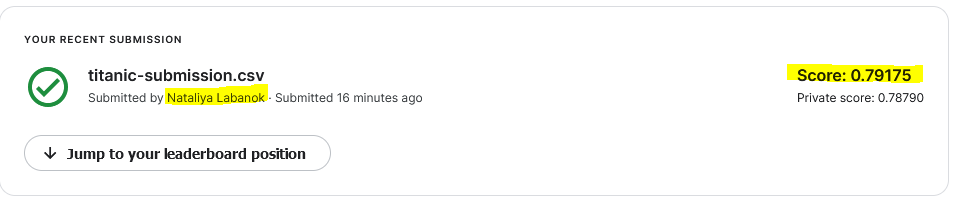